# Predicition of the jet engine RUL

В течение срока службы компоненты самолета подвержены деградации, что напрямую влияет на их надежность и производительность.  
Этот проект машинного обучения будет направлен на создание основы для прогнозирования оставшегося срока службы самолета (RUL)  
на основе данных всего жизненного цикла, чтобы обеспечить необходимое поведение при техническом обслуживании. 

# Dataset
https://www.kaggle.com/datasets/behrad3d/nasa-cmaps/data

Наборы данных состоят из нескольких многомерных временных рядов. Каждый набор данных далее делится на обучающую и тестовую подгруппы.  
Каждый временной ряд относится к разным двигателям, т. е. можно считать, что данные относятся к парку двигателей одного и того же типа.  
Каждый двигатель запускается с разной степенью начального износа и производственными отклонениями, которые неизвестны пользователю.  
Этот износ и изменения считаются нормальными, т. е. не считаются неисправностью. Существует три рабочих параметра,  
которые существенно влияют на работу двигателя. Эти настройки также включены в данные. 

## Features

    Index Names:
        "engine" : Engine No.
        "cycle" : Time, In Cycles

    Setting Names:
        "setting1" : Operation Setting 1
        "setting2" : Operation Setting 2
        "setting3" : Operation Setting 3

    Sensor Names:
        "sensor1" : Fan Inlet Temperature (◦R)
        "sensor2" : LPC Outlet Temperature (◦R)
        "sensor3" : HPC Outlet Temperature (◦R)
        "sensor4" : LPT Outlet Temperature (◦R)
        "sensor5" : Fan Inlet Pressure (psia)
        "sensor6" : Bypass-Duct Pressure (psia)
        "sensor7" : HPC Outlet Pressure (psia)
        "sensor8" : Physical Fan Speed (rpm)
        "sensor9" : Physical Core Speed (rpm)
        "sensor10" : Engine Pressure Ratio(P50/P2)
        "sensor11" : HPC Outlet Static Pressure (psia)
        "sensor12" : Ratio of Fuel Flow to Ps30 (pps/psia)
        "sensor13" : Corrected Fan Speed (rpm)
        "sensor14" : Corrected Core Speed (rpm)
        "sensor15" : Bypass Ratio
        "sensor16" : Burner Fuel-Air Ratio
        "sensor17" : Bleed Enthalpy
        "sensor18" : Required Fan Speed
        "sensor19" : Required Fan Conversion Speed
        "sensor20" : High-Pressure Turbines Cool Air Flow
        "sensor21" : Low-Pressure Turbines Cool Air Flow


![](https://upload.wikimedia.org/wikipedia/commons/thumb/7/75/Turbofan_operation.svg/450px-Turbofan_operation.svg.png)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

import warnings
warnings.filterwarnings("ignore")

In [2]:
index_names = ['unit_number', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = [ 
    "Fan inlet temperature",
    "LPC outlet temperature",
    "HPC outlet temperature",
    "LPT outlet temperature",
    "Fan inlet Pressure",
    "bypass-duct pressure",
    "HPC outlet pressure",
    "Physical fan speed",
    "Physical core speed",
    "Engine pressure ratio",
    "HPC outlet Static pressure",
    "Ratio of fuel flow to Ps30",
    "Corrected fan speed",
    "Corrected core speed",
    "Bypass Ratio",
    "Burner fuel-air ratio",
    "Bleed Enthalpy",
    "Required fan speed",
    "Required fan conversion speed",
    "High-pressure turbines Cool air flow",
    "Low-pressure turbines Cool air flow" 
]
col_names = index_names + setting_names + sensor_names

In [3]:
train_data = pd.read_csv('./CMaps/train_FD001.txt', sep='\s+', header=None, index_col=False, names=col_names)
test_data  = pd.read_csv('./CMaps/test_FD001.txt', sep='\s+', header=None, index_col=False, names=col_names)
y          = pd.read_csv('./CMaps/RUL_FD001.txt', sep='\s+', header=None, index_col=False, names=['RUL'])

# EDA

In [4]:
train_data

,unit_number,time_cycles,setting_1,setting_2,setting_3,Fan inlet temperature,LPC outlet temperature,HPC outlet temperature,LPT outlet temperature,Fan inlet Pressure,...,Ratio of fuel flow to Ps30,Corrected fan speed,Corrected core speed,Bypass Ratio,Burner fuel-air ratio,Bleed Enthalpy,Required fan speed,Required fan conversion speed,High-pressure turbines Cool air flow,Low-pressure turbines Cool air flow
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,519.49,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,519.68,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,520.01,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,519.67,2388.23,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640


In [5]:
train_data.isna().sum()

unit_number                             0
time_cycles                             0
setting_1                               0
setting_2                               0
setting_3                               0
Fan inlet temperature                   0
LPC outlet temperature                  0
HPC outlet temperature                  0
LPT outlet temperature                  0
Fan inlet Pressure                      0
bypass-duct pressure                    0
HPC outlet pressure                     0
Physical fan speed                      0
Physical core speed                     0
Engine pressure ratio                   0
HPC outlet Static pressure              0
Ratio of fuel flow to Ps30              0
Corrected fan speed                     0
Corrected core speed                    0
Bypass Ratio                            0
Burner fuel-air ratio                   0
Bleed Enthalpy                          0
Required fan speed                      0
Required fan conversion speed     

Рассмотрим распределение кол-ва циклов, перед поломокой двигаталей 

In [6]:
train_data.loc[:,['time_cycles']].describe()

,time_cycles
count,20631.000000
mean,108.807862
std,68.880990
min,1.000000
25%,52.000000
50%,104.000000
75%,156.000000
max,362.000000


Text(0.5, 9.444444444444459, 'max time cycle')

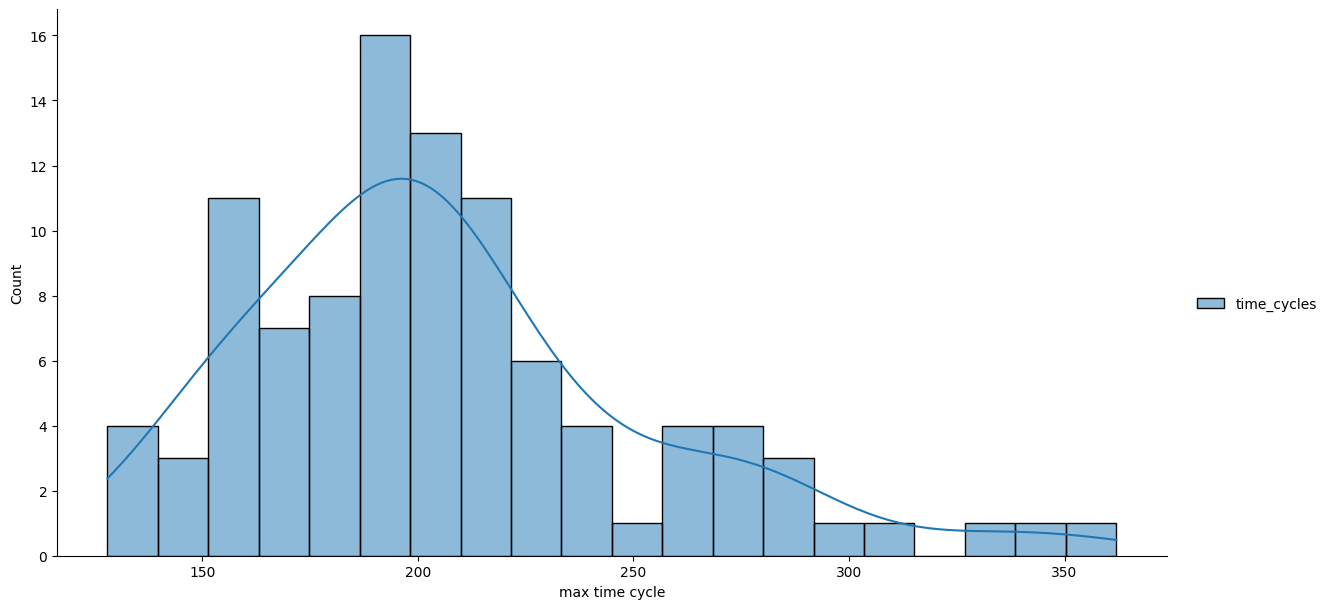

In [7]:
sns.displot(train_data[index_names].groupby('unit_number').max(), kde=True, bins=20, height=6, aspect=2)
plt.xlabel('max time cycle')

Видим, что в большенстве случаев максимальное кол-во циклов до отказа двигателя (190 - 210)

Добавим целевую переменную к train_data

In [8]:
def add_RUL(df):
    train_grouped_by_unit = df.groupby(by='unit_number') 
    max_time_cycles = train_grouped_by_unit['time_cycles'].max() 
    merged = df.merge(max_time_cycles.to_frame(name='max_time_cycle'), left_on='unit_number', right_index=True)
    merged["RUL"] = merged["max_time_cycle"] - merged['time_cycles']
    merged = merged.drop("max_time_cycle", axis=1) 
    return merged

train_data = add_RUL(train_data)

Оценим корреляцию фичей

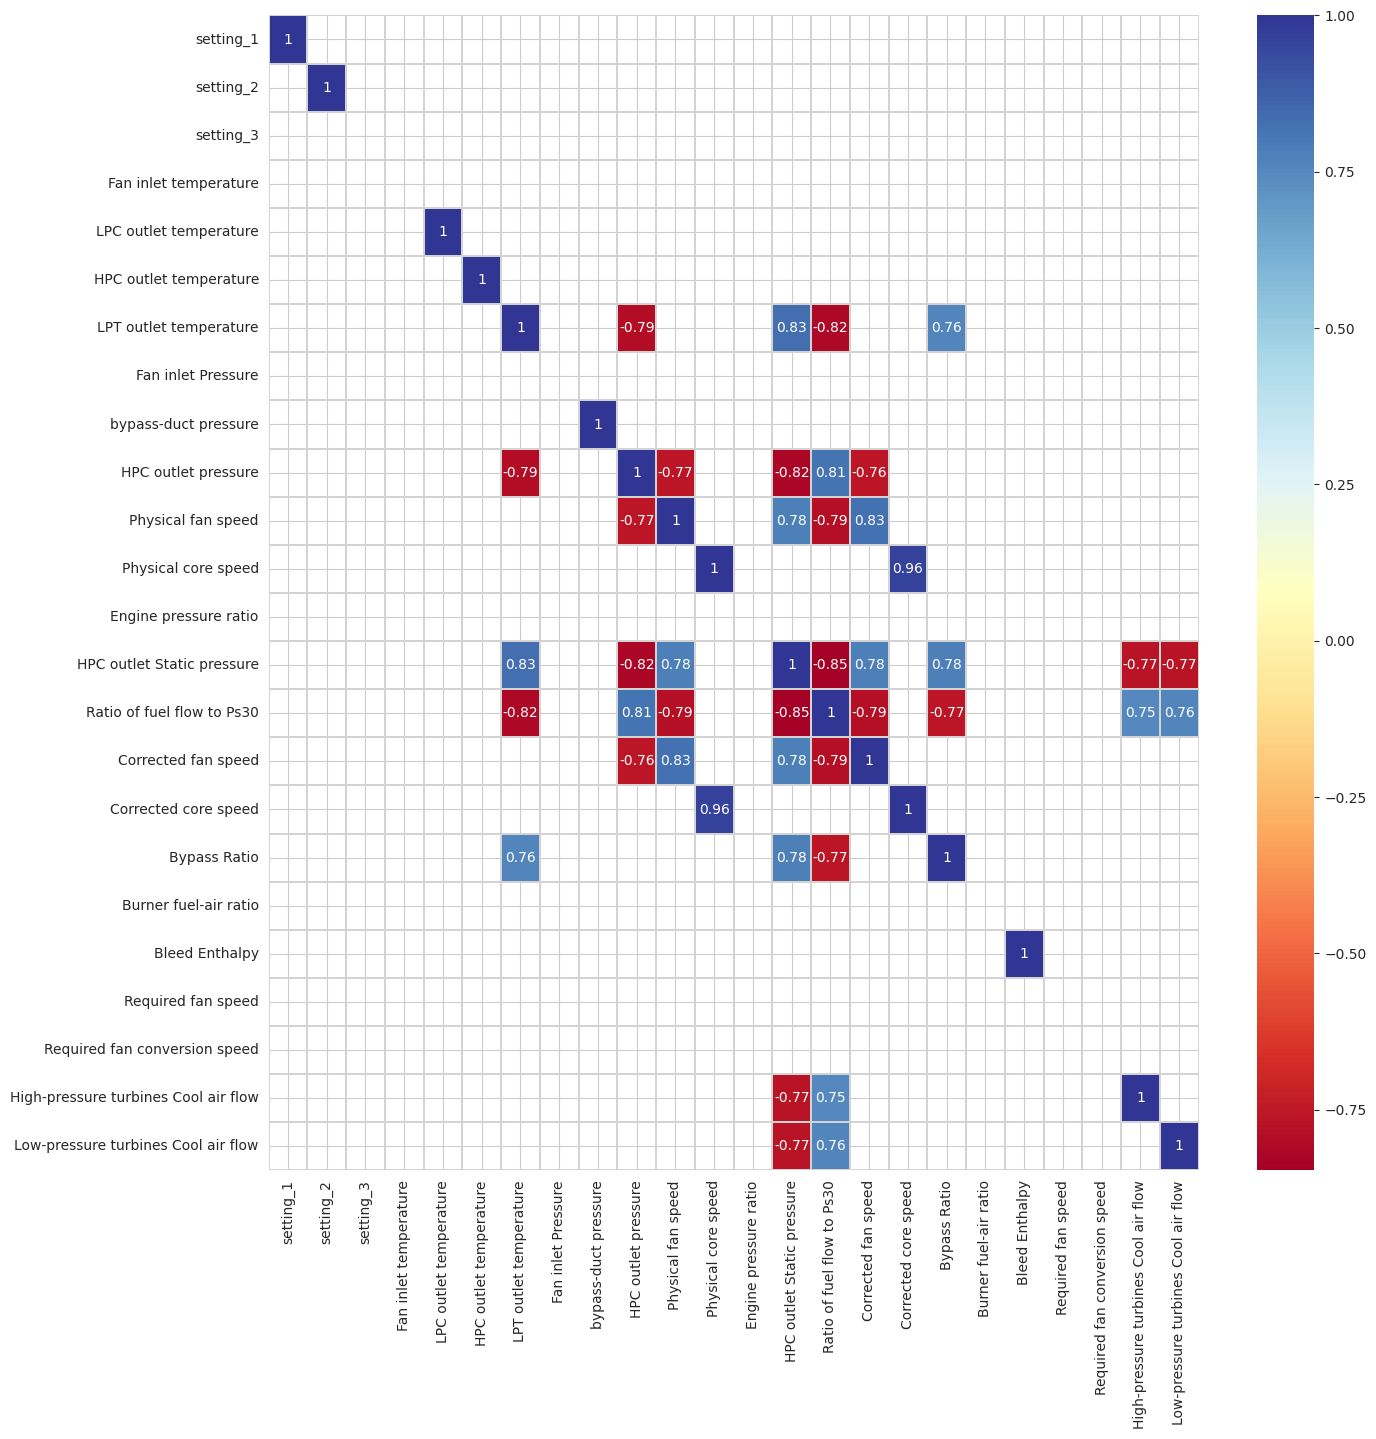

In [9]:
plt.figure(figsize=(15, 15))
threshold = 0.75
sns.set_style("whitegrid", {"axes.facecolor": ".0"})
df_corr = train_data[setting_names + sensor_names].corr()
mask = df_corr.where((abs(df_corr) >= threshold)).isna()
plot_kws={"s": 1}
sns.heatmap(
    df_corr,
    cmap='RdYlBu',
    annot=True,
    mask=mask,
    linewidths=0.2, 
    linecolor='lightgrey'
).set_facecolor('white')

Удалим столбцы с высокой корреляцией

In [10]:
cor_matrix = df_corr.abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(bool))
corr_features = [column for column in upper_tri.columns if any(upper_tri[column] > threshold)]
print(corr_features)
train_data.drop(corr_features, axis=1, inplace=True)
test_data.drop(corr_features, axis=1, inplace=True)

['HPC outlet pressure', 'Physical fan speed', 'HPC outlet Static pressure', 'Ratio of fuel flow to Ps30', 'Corrected fan speed', 'Corrected core speed', 'Bypass Ratio', 'High-pressure turbines Cool air flow', 'Low-pressure turbines Cool air flow']


Посмотрим на сигналы датчиков

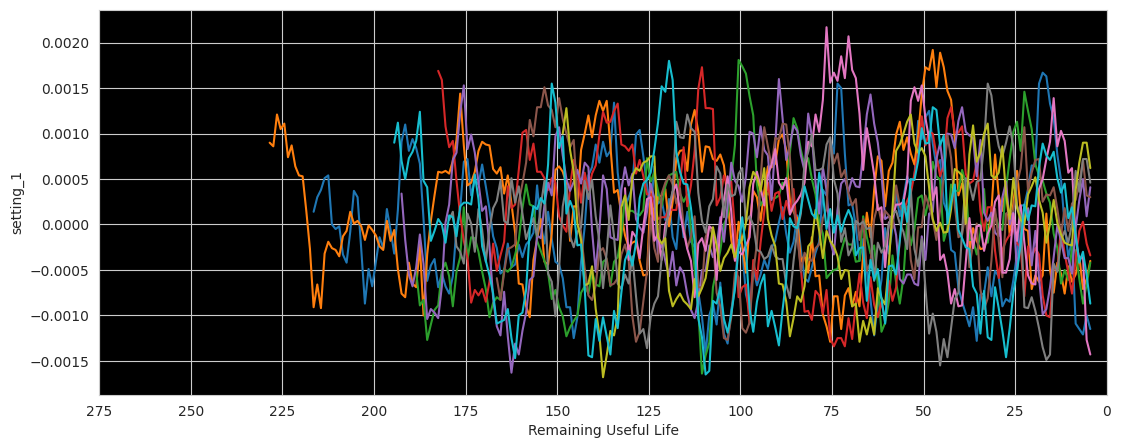

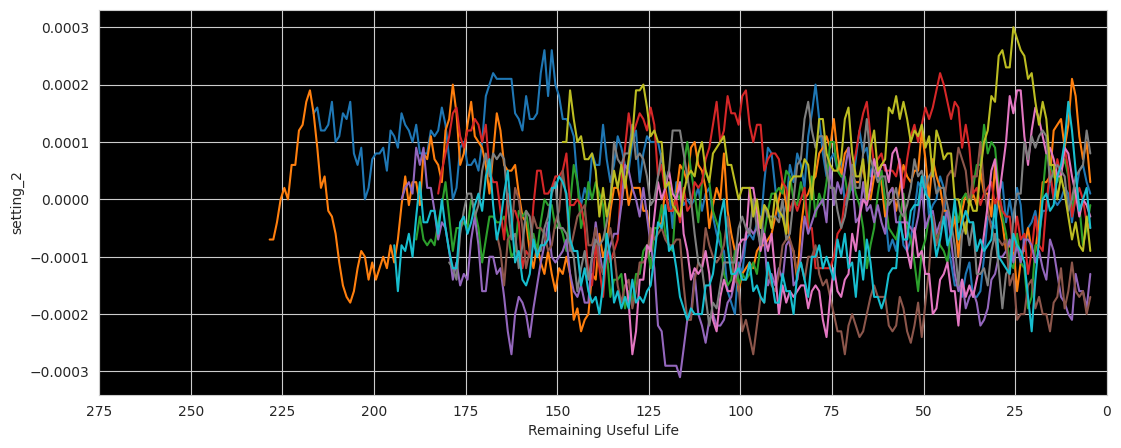

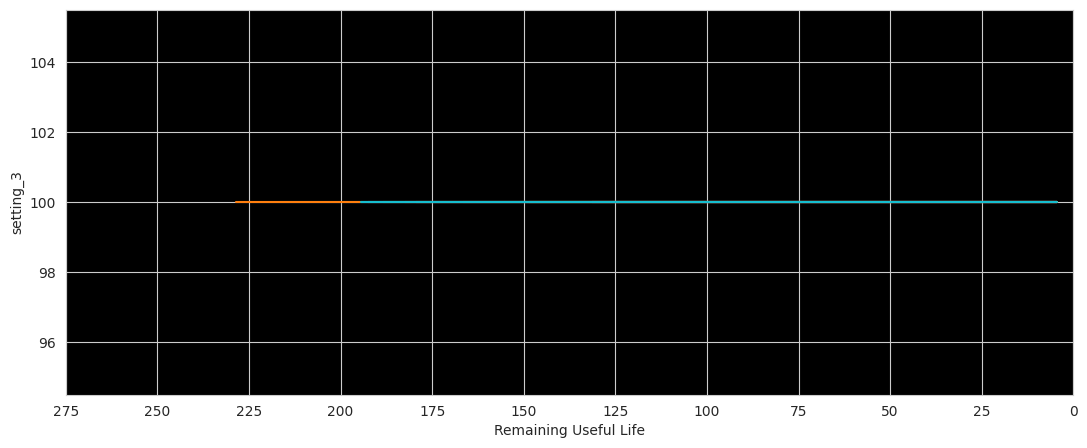

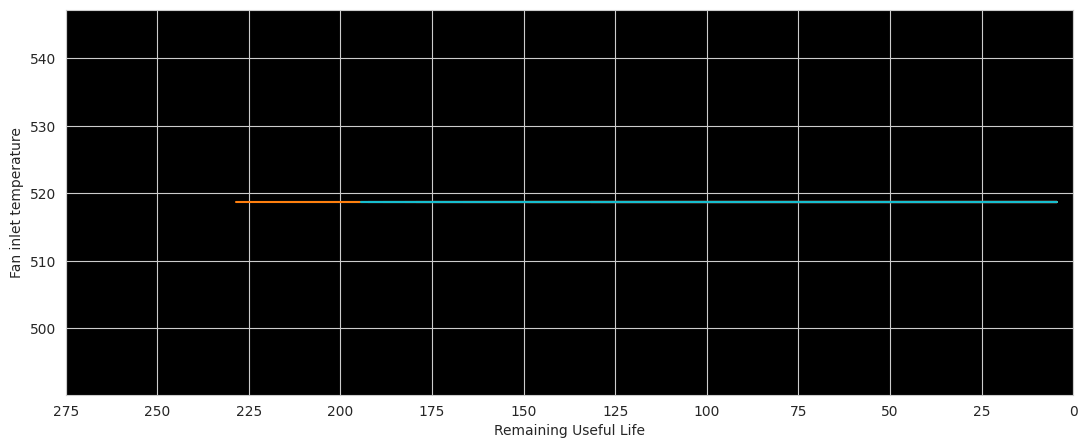

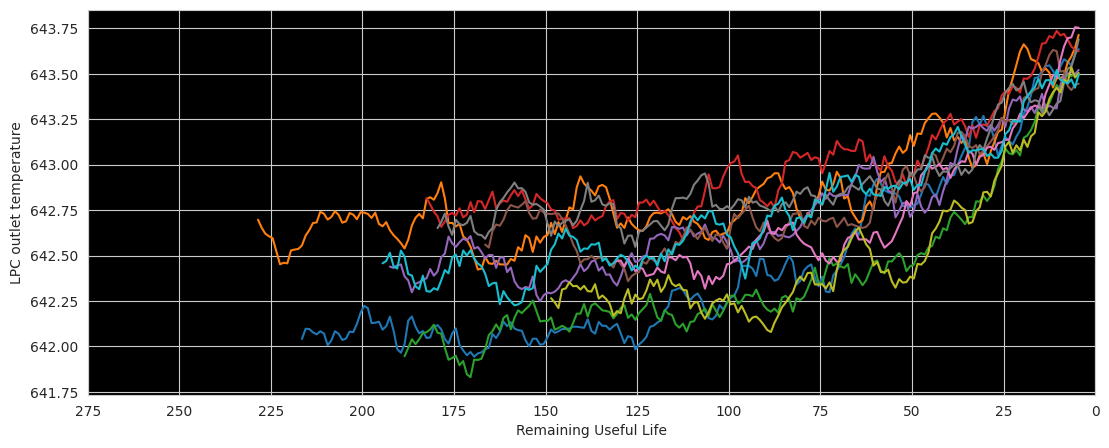

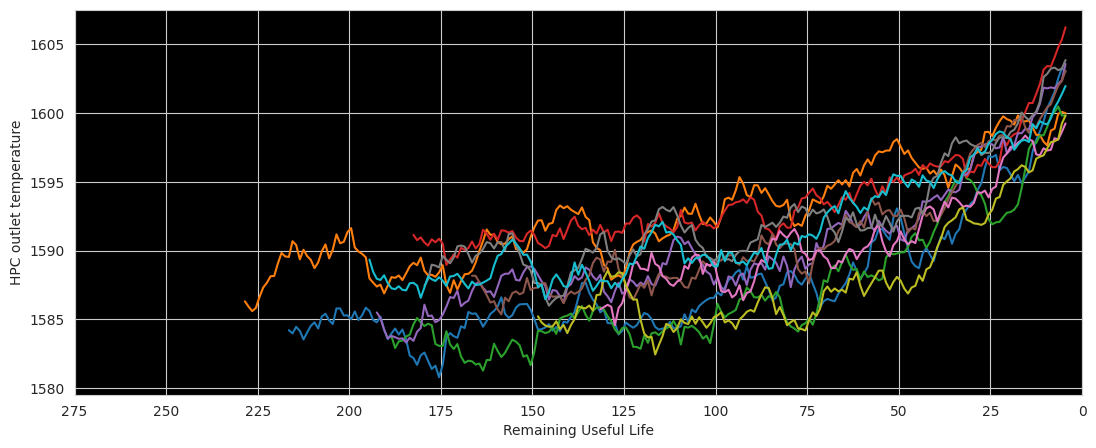

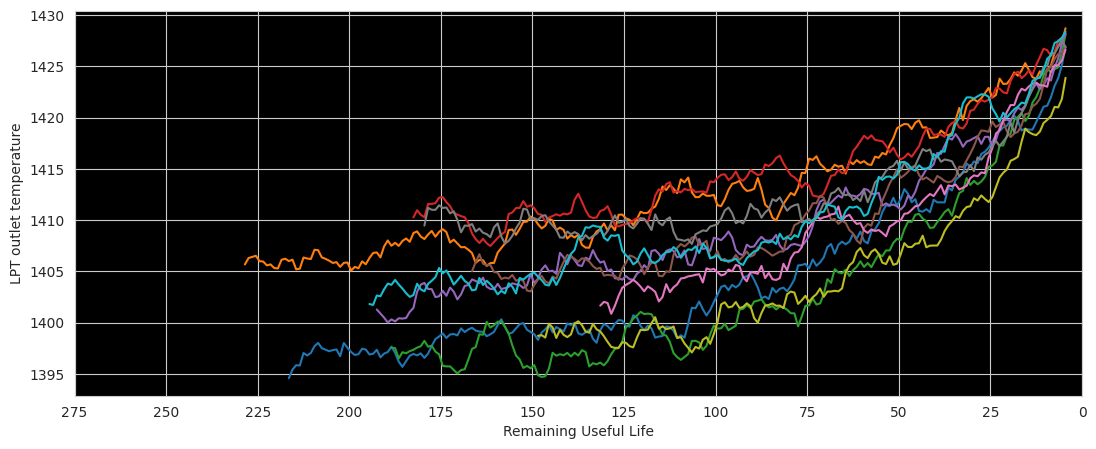

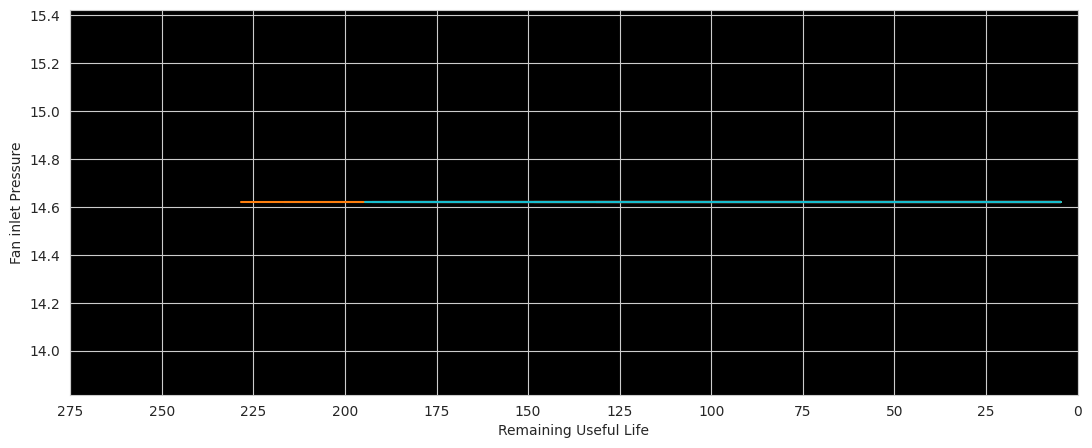

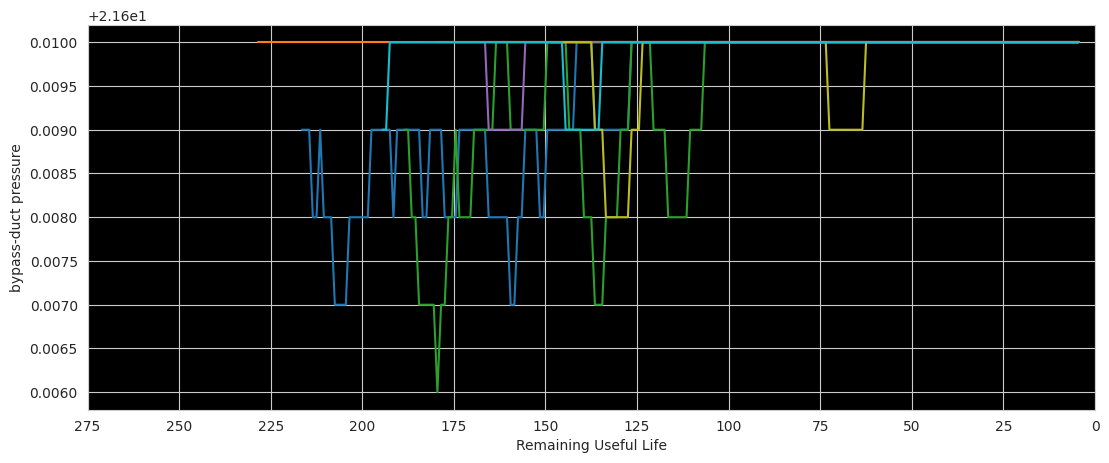

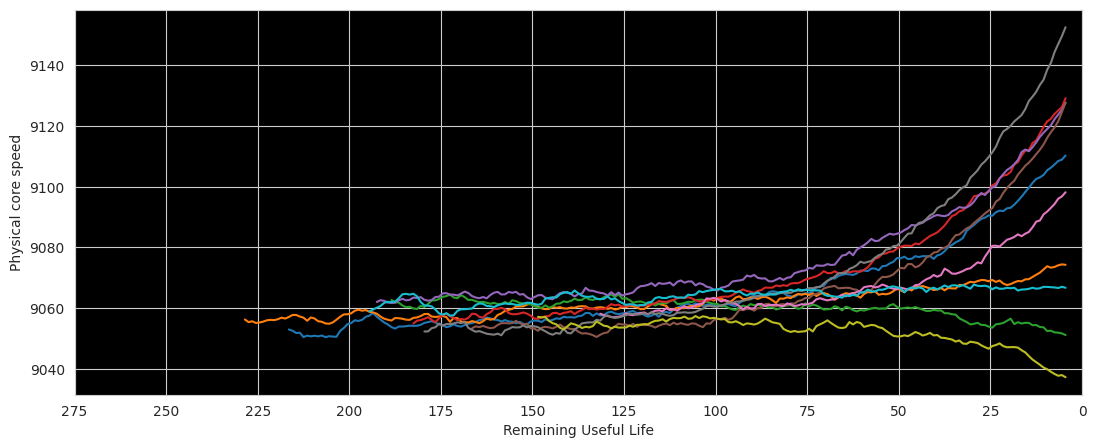

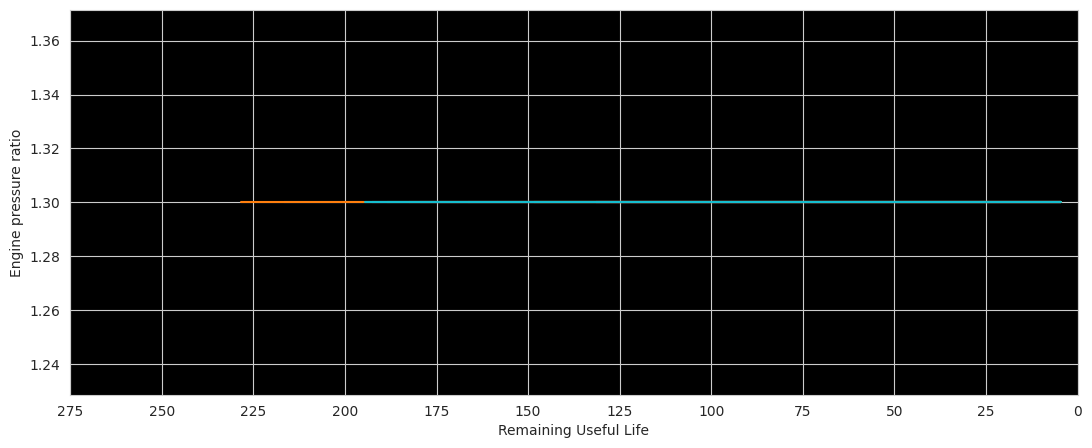

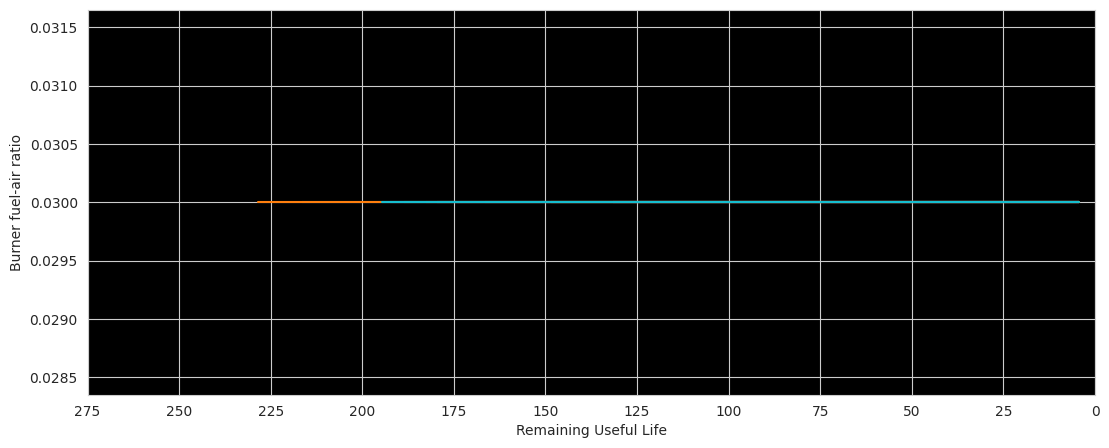

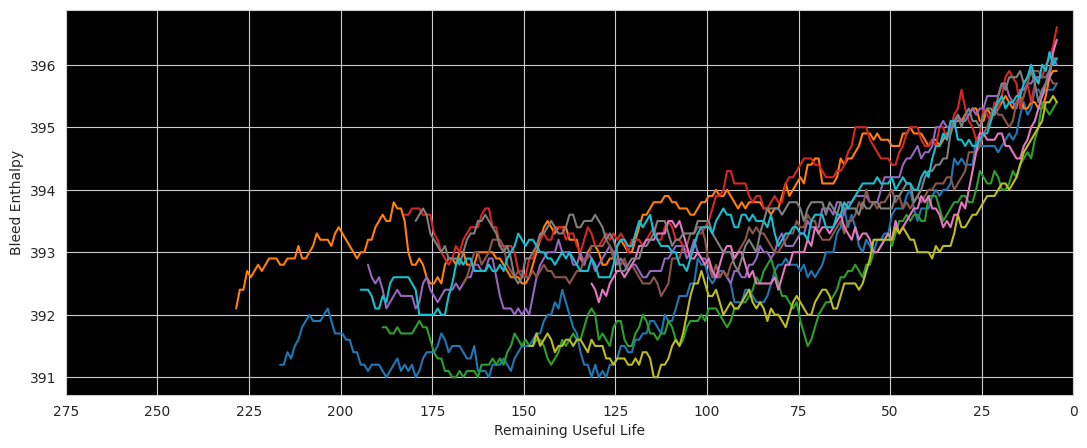

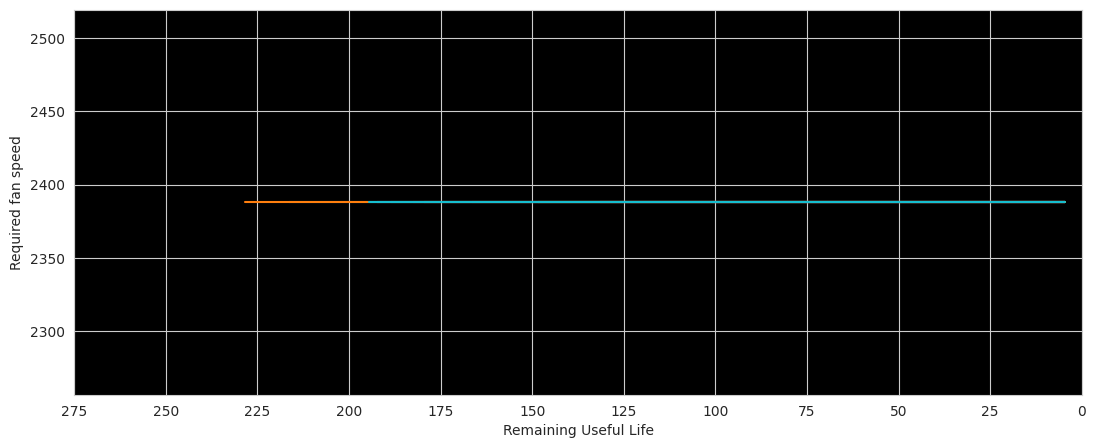

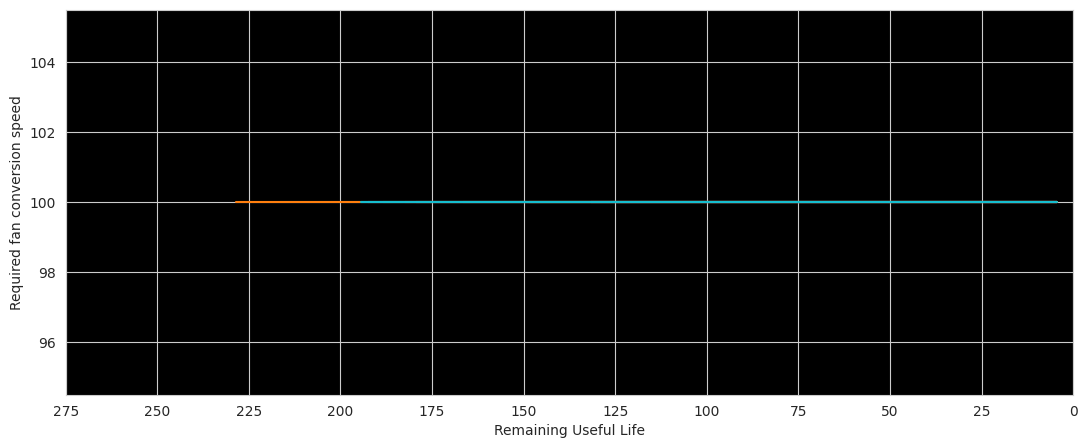

In [11]:
plot_data_columns = train_data.copy().drop(index_names + ['RUL'], axis=1).columns

for column_name in plot_data_columns:
    plt.figure(figsize=(13,5))
    for i in train_data['unit_number'].unique():
        if (i % 10 == 0):
            plt.plot('RUL', column_name, data=train_data[train_data['unit_number']==i].rolling(10).mean())
    plt.xlim(250, 0)
    plt.xticks(np.arange(0, 300, 25))
    plt.ylabel(column_name)
    plt.xlabel('Remaining Useful Life')
    plt.show()

Видим, что некоторые сигналы являются постоянными - удалим их из датасета

In [12]:
const_signals = [feature for feature in plot_data_columns if train_data[feature].min() == train_data[feature].max()]
const_signals.append('bypass-duct pressure')
train_data.drop(const_signals, axis=1, inplace=True)
test_data.drop(const_signals, axis=1, inplace=True)

![](https://upload.wikimedia.org/wikipedia/commons/thumb/7/75/Turbofan_operation.svg/450px-Turbofan_operation.svg.png)

In [13]:
train_data

,unit_number,time_cycles,setting_1,setting_2,LPC outlet temperature,HPC outlet temperature,LPT outlet temperature,Physical core speed,Bleed Enthalpy,RUL
0,1,1,-0.0007,-0.0004,641.82,1589.70,1400.60,9046.19,392,191
1,1,2,0.0019,-0.0003,642.15,1591.82,1403.14,9044.07,392,190
2,1,3,-0.0043,0.0003,642.35,1587.99,1404.20,9052.94,390,189
3,1,4,0.0007,0.0000,642.35,1582.79,1401.87,9049.48,392,188
4,1,5,-0.0019,-0.0002,642.37,1582.85,1406.22,9055.15,393,187
...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,643.49,1597.98,1428.63,9065.52,397,4
20627,100,197,-0.0016,-0.0005,643.54,1604.50,1433.58,9065.11,395,3
20628,100,198,0.0004,0.0000,643.42,1602.46,1428.18,9065.90,398,2
20629,100,199,-0.0011,0.0003,643.23,1605.26,1426.53,9073.72,395,1


Добавим лаги для каждого временного ряда. Количество лагов возьмем равным 100, так-как минимальное кол-во циклов работы двигателя ~ 150 дней

In [14]:
NUM_LAGS = 100
columns_to_lag = [
    'setting_1',
    'setting_2',
    'LPC outlet temperature',
    'HPC outlet temperature',
    'LPT outlet temperature',
    'Physical core speed',
    'Bleed Enthalpy',
]

def create_lags(data, lags, column):
    position = data.columns.get_loc(column)  # Изначальная позиция столбца
    for lag in range(1, lags):
        lagged_column = data[column].shift(lag)
        lagged_column_name = f"{column}_lag_{lag}"
        # Вставляем лаг непосредственно перед исходным столбцом
        data.insert(position, lagged_column_name, lagged_column)
    return data

def data_with_lags(df):
    df_lagged = pd.DataFrame()
    for unit in df['unit_number'].unique():
        unit_data = df[df['unit_number'] == unit].copy()
        for column in columns_to_lag:
            unit_data = create_lags(unit_data, NUM_LAGS, column)
        # Удаляем строки с NaN значениями, которые появляются из-за сдвига
        unit_data = unit_data.dropna().reset_index(drop=True)
        # Объединяем данные
        df_lagged = pd.concat([df_lagged, unit_data], axis=0)
    return df_lagged.reset_index(drop=True)

Разделим тестовый датасет на test и val

In [15]:
from sklearn.model_selection import train_test_split

def make_val_test_data(data, target):
    target['unit_number'] = target.index + 1
    # Добавляем RUL к каждому циклу для каждого unit_number
    data = data.merge(target, on='unit_number', how='left')
    # Вычисляем RUL для каждого цикла
    data['RUL'] = data.groupby('unit_number')['RUL'].transform(lambda x: x.max()) - \
                  data['time_cycles'] + \
                  data.groupby('unit_number')['time_cycles'].transform('max')
    unique_units = data['unit_number'].unique()
    test_units, val_units = train_test_split(unique_units, test_size=0.3, random_state=RANDOM_SEED)

    test_df = data[data['unit_number'].isin(test_units)]
    val_df = data[data['unit_number'].isin(val_units)]

    return test_df, val_df

test_data, val_data = make_val_test_data(test_data, y)

In [16]:
train_data = data_with_lags(train_data)
test_data = data_with_lags(test_data)
val_data = data_with_lags(val_data)

In [17]:
val_data

,unit_number,time_cycles,setting_1_lag_99,setting_1_lag_98,setting_1_lag_97,setting_1_lag_96,setting_1_lag_95,setting_1_lag_94,setting_1_lag_93,setting_1_lag_92,...,Bleed Enthalpy_lag_8,Bleed Enthalpy_lag_7,Bleed Enthalpy_lag_6,Bleed Enthalpy_lag_5,Bleed Enthalpy_lag_4,Bleed Enthalpy_lag_3,Bleed Enthalpy_lag_2,Bleed Enthalpy_lag_1,Bleed Enthalpy,RUL
0,10,100,-0.0017,0.0061,0.0027,-0.0028,0.0013,-0.0007,0.0006,0.0024,...,391.0,392.0,393.0,392.0,392.0,391.0,392.0,393.0,391,188
1,10,101,0.0061,0.0027,-0.0028,0.0013,-0.0007,0.0006,0.0024,-0.0006,...,392.0,393.0,392.0,392.0,391.0,392.0,393.0,391.0,392,187
2,10,102,0.0027,-0.0028,0.0013,-0.0007,0.0006,0.0024,-0.0006,-0.0008,...,393.0,392.0,392.0,391.0,392.0,393.0,391.0,392.0,391,186
3,10,103,-0.0028,0.0013,-0.0007,0.0006,0.0024,-0.0006,-0.0008,0.0017,...,392.0,392.0,391.0,392.0,393.0,391.0,392.0,391.0,391,185
4,10,104,0.0013,-0.0007,0.0006,0.0024,-0.0006,-0.0008,0.0017,-0.0025,...,392.0,391.0,392.0,393.0,391.0,392.0,391.0,391.0,394,184
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1445,97,130,0.0042,0.0018,0.0017,-0.0026,-0.0028,-0.0023,-0.0052,-0.0021,...,391.0,393.0,393.0,393.0,393.0,394.0,392.0,392.0,393,86
1446,97,131,0.0018,0.0017,-0.0026,-0.0028,-0.0023,-0.0052,-0.0021,0.0016,...,393.0,393.0,393.0,393.0,394.0,392.0,392.0,393.0,395,85
1447,97,132,0.0017,-0.0026,-0.0028,-0.0023,-0.0052,-0.0021,0.0016,-0.0004,...,393.0,393.0,393.0,394.0,392.0,392.0,393.0,395.0,393,84
1448,97,133,-0.0026,-0.0028,-0.0023,-0.0052,-0.0021,0.0016,-0.0004,0.0036,...,393.0,393.0,394.0,392.0,392.0,393.0,395.0,393.0,392,83


In [18]:
drop_for_X = [
    'unit_number',
    'time_cycles',
    'RUL'
]

X_train, y_train = train_data.drop(drop_for_X, axis=1), train_data['RUL']
X_test, y_test = test_data.drop(drop_for_X, axis=1), test_data['RUL']
X_val, y_val = val_data.drop(drop_for_X, axis=1), val_data['RUL']

Функция для расчета ошибок

In [19]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

def error(y_true, y):
    print('MAE:', mean_absolute_error(y_true, y))
    print('MAPE:',mean_absolute_percentage_error(y_true, y))
    print('MSE:', mean_squared_error(y_true, y, squared=False))

# LinearRegression

In [20]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)

lr_pred = model.predict(X_test)

In [21]:
error(y_test, lr_pred)

MAE: 24.591007353643086
MAPE: 0.319627292340151
MSE: 32.49940713294366


# Boosting

In [22]:
import xgboost as xgb

model = xgb.XGBRFRegressor(objective='reg:squarederror', n_estimators=1000)
model.fit(X_train, y_train)

boosting_pred = model.predict(X_test)

In [23]:
error(y_test, boosting_pred)

MAE: 26.52187671159443
MAPE: 0.32049143012439035
MSE: 36.400428099115864


In [24]:
FRAME_COLUMNS = train_data.drop(drop_for_X, axis=1).columns
FRAME_COLUMNS

Index(['setting_1_lag_99', 'setting_1_lag_98', 'setting_1_lag_97',
       'setting_1_lag_96', 'setting_1_lag_95', 'setting_1_lag_94',
       'setting_1_lag_93', 'setting_1_lag_92', 'setting_1_lag_91',
       'setting_1_lag_90',
       ...
       'Bleed Enthalpy_lag_9', 'Bleed Enthalpy_lag_8', 'Bleed Enthalpy_lag_7',
       'Bleed Enthalpy_lag_6', 'Bleed Enthalpy_lag_5', 'Bleed Enthalpy_lag_4',
       'Bleed Enthalpy_lag_3', 'Bleed Enthalpy_lag_2', 'Bleed Enthalpy_lag_1',
       'Bleed Enthalpy'],
      dtype='object', length=700)

Функция для выделения нужных колонок для определенных голов multi-head моделей

In [25]:
FRAME_COLUMNS = train_data.drop(drop_for_X, axis=1).columns

def columns_for_head(name):
    head_columns = [f"{name}_lag_{lag}" for lag in range(1, NUM_LAGS)][::-1] + [name]
    start = FRAME_COLUMNS.get_loc(head_columns[0])
    end   = FRAME_COLUMNS.get_loc(head_columns[-1]) + 1
    return slice(start, end)

[columns_for_head(name) for name in columns_to_lag]

[slice(0, 100, None),
 slice(100, 200, None),
 slice(200, 300, None),
 slice(300, 400, None),
 slice(400, 500, None),
 slice(500, 600, None),
 slice(600, 700, None)]

# Multi-head LinerRegression

In [28]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import StackingRegressor
from sklearn.compose import ColumnTransformer
    
def make_heads(base_model, base_model_name='model'):
    preprocessors = [ColumnTransformer(transformers=[(           \
        f'{name}_columns', 'passthrough', columns_for_head(name) \
    )]) for name in columns_to_lag]

    
    base_estimators = [(f"{base_model_name}_{name}", Pipeline(
        steps=[('select', preprocessor), (f"{base_model_name}_{name}", base_model)])
    ) for preprocessor, name in zip(preprocessors, columns_to_lag)]

    meta_regressor = base_model
    
    return StackingRegressor(
        estimators=base_estimators,
        final_estimator=meta_regressor
    )

multi_head_lr = make_heads(LinearRegression(), 'lr')

# Обучение пайплайна
multi_head_lr.fit(X_train, y_train)

StackingRegressor(estimators=[('lr_setting_1',
                               Pipeline(steps=[('select',
                                                ColumnTransformer(transformers=[('setting_1_columns',
                                                                                 'passthrough',
                                                                                 slice(0, 100, None))])),
                                               ('lr_setting_1',
                                                LinearRegression())])),
                              ('lr_setting_2',
                               Pipeline(steps=[('select',
                                                ColumnTransformer(transformers=[('setting_2_columns',
                                                                                 'passthrough',
                                                                                 slice(100, 200, None))])),
                                               ('lr_setting_2',
                                                L...
                                                ColumnTransformer(transformers=[('Physical '
                                                                                 'core '
                                                                                 'speed_columns',
                                                                                 'passthrough',
                                                                                 slice(500, 600, None))])),
                                               ('lr_Physical core speed',
                                                LinearRegression())])),
                              ('lr_Bleed Enthalpy',
                               Pipeline(steps=[('select',
                                                ColumnTransformer(transformers=[('Bleed '
                                                                                 'Enthalpy_columns',
                                                                                 'passthrough',
                                                                                 slice(600, 700, None))])),
                                               ('lr_Bleed Enthalpy',
                                                LinearRegression())]))],
                  final_estimator=LinearRegression())

In [29]:
mh_lr_pred = multi_head_lr.predict(X_test)

In [30]:
error(y_test, mh_lr_pred)

MAE: 25.362771929037756
MAPE: 0.3095780062213535
MSE: 34.26387166426246


# Multi-head Boosting

In [33]:
multi_head_boosting = make_heads(xgb.XGBRFRegressor(objective='reg:squarederror', n_estimators=1000), 'boost')

multi_head_boosting.fit(X_train, y_train)

StackingRegressor(estimators=[('boost_setting_1',
                               Pipeline(steps=[('select',
                                                ColumnTransformer(transformers=[('setting_1_columns',
                                                                                 'passthrough',
                                                                                 slice(0, 100, None))])),
                                               ('boost_setting_1',
                                                XGBRFRegressor(base_score=None,
                                                               booster=None,
                                                               callbacks=None,
                                                               colsample_bylevel=None,
                                                               colsample_bytree=None,
                                                               device=None,
                                                               early_stopping_rounds=None,
                                                               enable_categorical=False...
                                                 importance_type=None,
                                                 interaction_constraints=None,
                                                 max_bin=None,
                                                 max_cat_threshold=None,
                                                 max_cat_to_onehot=None,
                                                 max_delta_step=None,
                                                 max_depth=None,
                                                 max_leaves=None,
                                                 min_child_weight=None,
                                                 missing=nan,
                                                 monotone_constraints=None,
                                                 multi_strategy=None,
                                                 n_estimators=1000, n_jobs=None,
                                                 num_parallel_tree=None,
                                                 objective='reg:squarederror',
                                                 random_state=None,
                                                 reg_alpha=None, ...))

In [34]:
mh_boosting_pred = multi_head_boosting.predict(X_test)

In [35]:
error(y_test, mh_boosting_pred)

MAE: 29.93951203518595
MAPE: 0.36500784676899645
MSE: 39.50682128540005
